Домашнее задание: 

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю
 

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.




In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt

from IPython import display
from torchvision.utils import save_image, make_grid

import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cuda:0"
# device = "cpu"
device

device(type='cuda', index=0)

In [3]:
lr = 0.0002

b1 = 0.5
b2 = 0.999

BATCH_SIZE = 256
DATA_SIZE = BATCH_SIZE * 300

MIN_X = -50 #-1000
MAX_X = 50 # 1000

hidden_dim = 20 # 100

# noise random uniform min and max values
noise_min = -1.0
noise_max = 1.0

n_epochs = 500

In [4]:
y = lambda x: ((np.sin(x)/x) - (x/10))

In [5]:
x = np.linspace(MIN_X, MAX_X, 3500)

<function matplotlib.pyplot.show(close=None, block=None)>

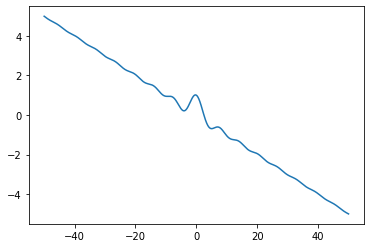

In [6]:
plt.plot(x, y(x))
plt.show

#### Делаем данные для обучения:

In [7]:
x_train = np.linspace(MIN_X, MAX_X, 150500)
np.random.shuffle(x_train)
x_train = x_train[:DATA_SIZE]
y_train = y(x_train)

In [8]:
train_data = np.array([[x_train[i], y_train[i]] for i in range(x_train.shape[0])])
train_data[:10]

array([[ 38.34145077,  -3.81852048],
       [-25.51877421,   2.5666319 ],
       [ 38.02649851,  -3.79419339],
       [-30.83110187,   3.06520446],
       [-22.84898903,   2.2517932 ],
       [ 22.23636037,  -2.23455337],
       [ 16.82037754,  -1.73535223],
       [ -0.79967309,   0.97674413],
       [ 26.12874504,  -2.5807526 ],
       [ -2.13390122,   0.60966046]])

In [9]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=12)
# next(iter(trainloader))

In [10]:
SAMPLES_COUNT_IN_DATASET =trainloader.dataset.data.shape[0]
SAMPLES_COUNT_IN_DATASET

76800

In [11]:
BATCHES_IN_DATA_COUNT = math.ceil(SAMPLES_COUNT_IN_DATASET / BATCH_SIZE)
BATCHES_IN_DATA_COUNT

300

### Генератор

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(hidden_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [13]:
gen_model = Generator().double().to(device)

#### Сгенерируем предсказание на необученном генераторе. Прост по приколу)

In [14]:
gen_model.eval()

x = Variable(torch.from_numpy(np.random.uniform(MIN_X, MAX_X, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(x)

gen_model.train()

Generator(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [15]:
test_pred = test_pred.cpu().detach().numpy()

In [16]:
p = test_pred[:,0].argsort()

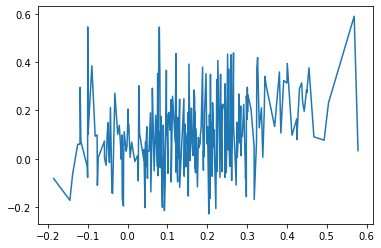

In [17]:
plt.plot(test_pred[:,0][p], test_pred[:, 1][p])
plt.show()

In [18]:
# np.random.uniform(-100, 100, (100, hidden_dim))

In [19]:
# test_pred[:,0][p]

In [20]:
# test_pred[:,1][p]

### Создание своих слоев (решил оставить на память себе)

In [21]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

#         nn.init.uniform_(self.weights, -0.005, 0.005) 
#         nn.init.uniform_(self.bias, -0.005, 0.005)  
        nn.init.uniform_(self.weights, -0.05, 0.05) 
        nn.init.uniform_(self.bias, -0.05, 0.05)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

### Дискриминатор

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, coords):
        coords_flat = coords.view(coords.size(0), -1)
        validity = self.model(coords_flat)

        return validity

In [23]:
discriminator_model = Discriminator().to(device)

#### Сгенерируем предсказание на необученном дискриминаторе. Тоже прост по приколу)

In [24]:
discriminator_model.eval()

# x = Variable(torch.from_numpy(test_pred.astype(np.float64))).double().to(device)
x = Variable(torch.from_numpy(test_pred)).to(device)

with torch.no_grad():
    test_pred2 = discriminator_model(x.float())

discriminator_model.train()

test_pred2 = test_pred2.cpu().detach().numpy()
test_pred2[:10]

array([[0.5067327 ],
       [0.50686675],
       [0.5067818 ],
       [0.50702095],
       [0.5065576 ],
       [0.50647306],
       [0.5066392 ],
       [0.50676525],
       [0.5062573 ],
       [0.50711817]], dtype=float32)

### Тренировка

In [25]:
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

[Epoch 500/500] [D loss: 0.677889] [G loss: 0.731876]


<Figure size 432x288 with 0 Axes>

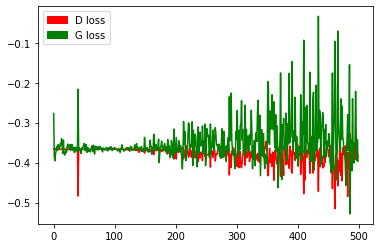

CPU times: user 29min 6s, sys: 4min 16s, total: 33min 22s
Wall time: 25min 41s


In [26]:
%%time

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    
    generator_epoch_loss = 0.0
    discriminator_epoch_loss = 0.0
    
    for i, data in enumerate(trainloader):
#         print(i, data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0), requires_grad=False).to(device)
        
        real_coords = Variable(data.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################
        
        optimizer_G.zero_grad()
    
        #генерация шума
#         z = Variable(torch.FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, hidden_dim)))).to(device)
#         z = Variable(torch.from_numpy(np.random.uniform(MIN_X, MAX_X, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)
        z = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

        gen_coords = gen_model(z)

        validity = discriminator_model(gen_coords.float())
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        generator_epoch_loss += g_loss.item()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator_model(real_coords.float())
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator_model(gen_coords.detach().float())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        discriminator_epoch_loss += d_loss.item()

######## Отображение процесса обучения и вывод функций потерь ############
        if (i+1) % BATCHES_IN_DATA_COUNT == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"% (epoch+1, n_epochs, discriminator_epoch_loss / BATCHES_IN_DATA_COUNT, generator_epoch_loss / BATCHES_IN_DATA_COUNT)) 

            
            display.display(plt.gcf())
            
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()


#### Проверка модели на данных во всем диапазоне

In [27]:
gen_model.eval()

xx = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(xx)

gen_model.train()

test_pred = test_pred.cpu().detach().numpy()

In [28]:
count = 0
error = 0.0
for i in range(len(test_pred)):
    xxx = test_pred[i][0]
    y_pred = test_pred[i][1]
    y_real = y(xxx)
    print("X: %.10f;\t" % xxx, "y_pred: %.10f;\t\t" % y_pred, "y_real: %.10f" % y_real)
    
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))

X: -30.3605685318;	 y_pred: 3.0432102728;		 y_real: 3.0073987354
X: -44.4859653443;	 y_pred: 4.4600665477;		 y_real: 4.4594458314
X: -17.7405849783;	 y_pred: 1.7549544578;		 y_real: 1.7235956393
X: -50.0540741234;	 y_pred: 5.0169532331;		 y_real: 5.0012152044
X: -21.0716508992;	 y_pred: 2.1142670636;		 y_real: 2.1449076097
X: 40.2427104348;	 y_pred: -4.0026037565;		 y_real: -4.0102812858
X: -22.0352511161;	 y_pred: 2.2148908408;		 y_real: 2.2015243064
X: 11.8690652089;	 y_pred: -1.1986156718;		 y_real: -1.2410097211
X: 44.0947381194;	 y_pred: -4.3914948019;		 y_real: -4.4069291957
X: 18.3328263877;	 y_pred: -1.7864087041;		 y_real: -1.8602309828
X: -45.8354143560;	 y_pred: 4.5978411549;		 y_real: 4.6044949161
X: -30.7685397895;	 y_pred: 3.0839400504;		 y_real: 3.0572526597
X: -8.2249264689;	 y_pred: 0.9237417814;		 y_real: 0.9358049380
X: 18.5697849535;	 y_pred: -1.8186696276;		 y_real: -1.8718486476
X: 23.0161433575;	 y_pred: -2.2562038825;		 y_real: -2.3387496398
X: -45.3204491604;	 

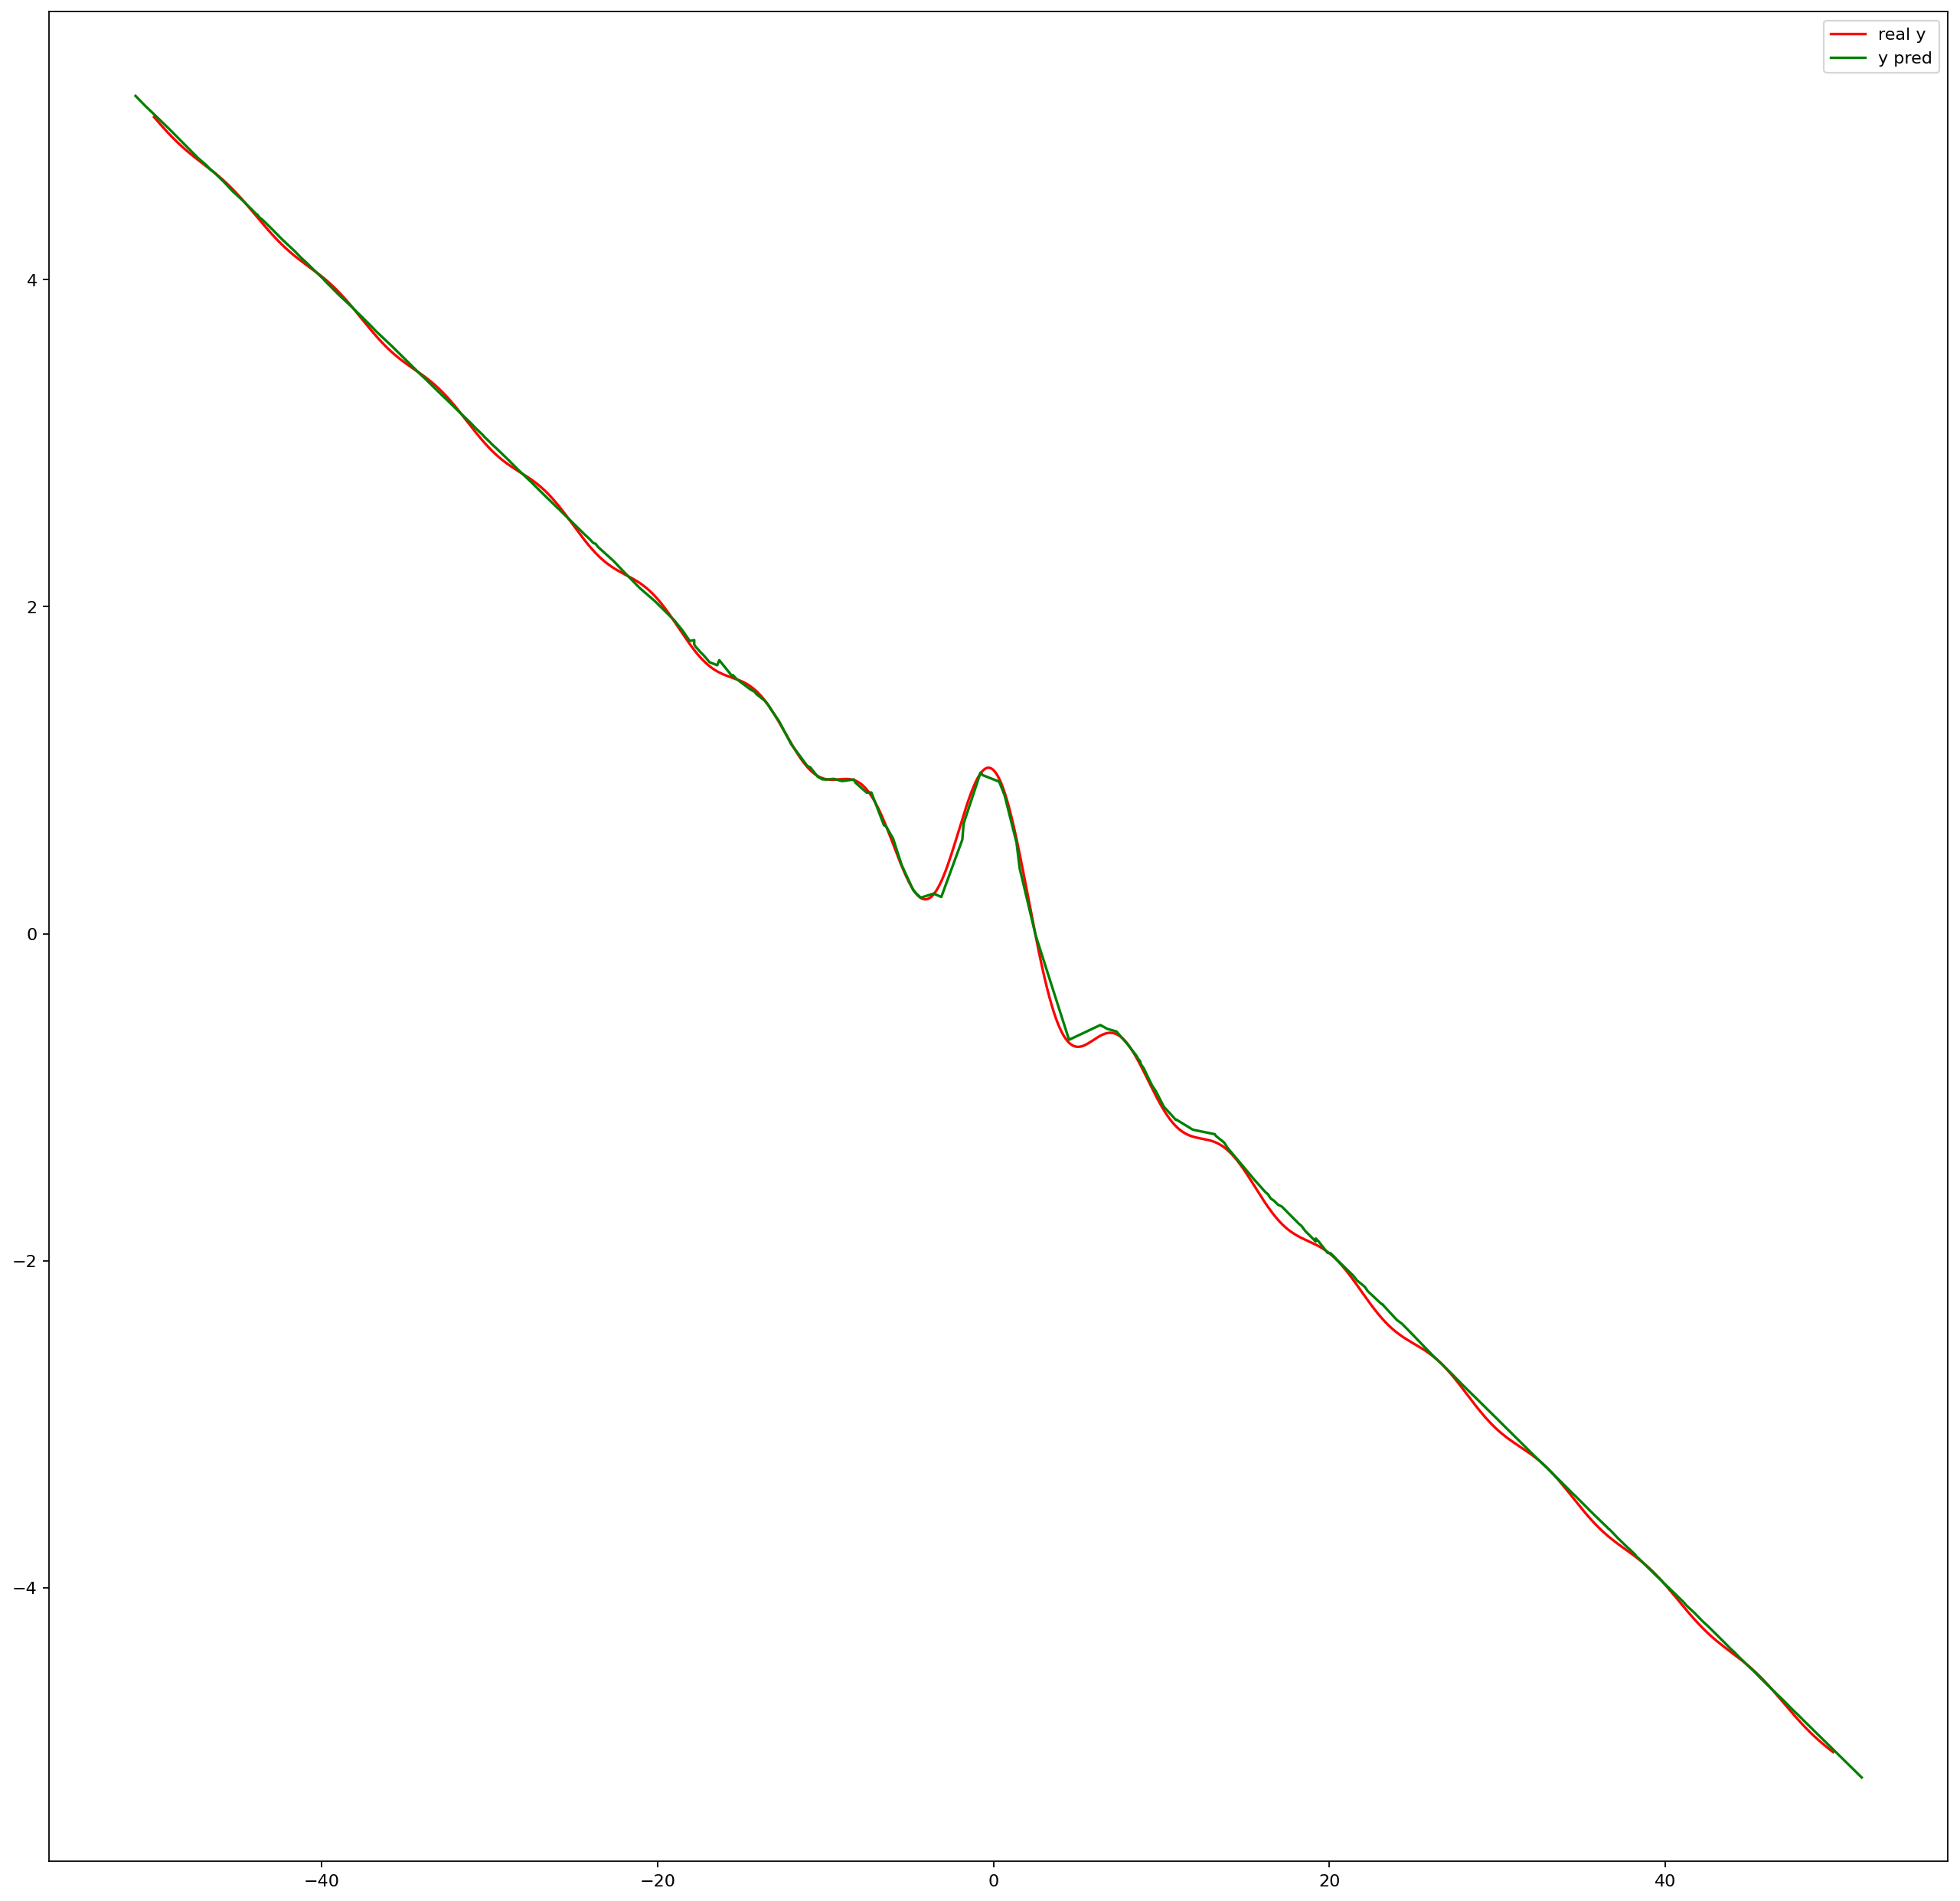

In [29]:
figure(num=None, figsize=(20, 20), dpi=160)

real_x = np.linspace(MIN_X, MAX_X, 3500)
plt.plot(real_x, y(real_x), label='real y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()